## **Extração de Características em Imagens**

In [1]:
## Importando as libs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.io import imread
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Suprimindo Warnings
import warnings
warnings.filterwarnings('ignore')


IMAGES_DATABASE_BASE_PATH = "/Users/gilcesarf/git/repositories/imd/imd3002-202502/image-database"

# Função para calcular a moda
def mode_func(x):
    return x.mode().iloc[0] if not x.mode().empty else x.iloc[0]

# Função para converter a imagem para escala de cinza
def convert_to_grayscale(img):
    return rgb2gray(img)

def convert_from_histogram_to_feature_attributes(histogram, base_name):
    # Criar DataFrame diretamente com as features como colunas
    df2 = pd.DataFrame(histogram.reshape(1, -1))
    df2.columns = df2.columns.map(lambda x: f'{base_name}_{x+1}')
    return df2

def apply_pca(features, perc_variancia):
    # Normalizar as features
    scaler = StandardScaler()
    fit = scaler.fit_transform(features)

    # Aplicar PCA com a variancia soliciatada
    pca = PCA(n_components=perc_variancia)

    return pca.fit_transform(fit)

# Função para extrair as features do LBP
def lbp_feature_extraction(lbp, n_points):
    # Criar histograma (descritor final)
    (hist, _) = np.histogram(
                    lbp.ravel(),
                    bins=np.arange(0, n_points + 3),
                    range=(0, n_points + 2))

    # Normalizar histograma
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7) # evita divisão por zero

    return convert_from_histogram_to_feature_attributes(hist, 'lbp_feature')

# Função para processar LBP para uma resolução específica e armazenar resultado no dataframe
def process_lbp_for_resolution(df_imagens, idx, gray_image, resolution, radius, n_points):
    """
    Procesa LBP para uma resolução especifica e armazena resultado no dataframe
    
    Args:
        df_imagens: DataFrame principal
        idx: índice da imagen corrente
        gray_image: imagem em escala de cinza
        resolution: resolucao
        radius: raio para LBP
        n_points: número de pontos para LBP
    """
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    
    # Armazenando array numpy diretamente
    # df_imagens.at[idx, f"lbp_{resolution}_{radius}_{n_points}"] = lbp
    df_imagens.at[idx, f"lbpfeat_{resolution}_{radius}_{n_points}"] = lbp_feature_extraction(lbp, n_points)
    print(
        f"\tLBP Raio {radius:02d} Pontos {n_points:03d} - {resolution}x{resolution} -"+
        # f"\tLBP shape: {df_imagens.at[idx, f'lbp_{resolution}_{radius}_{n_points}'].shape} -"+
        f"\tFeature shape: {df_imagens.at[idx, f'lbpfeat_{resolution}_{radius}_{n_points}'].shape}")

In [2]:
# Ler imagens do IMAGES_DATABASE_BASE_PATH e criar DataFrame
data_list = []
contador = 0
for filename in os.listdir(IMAGES_DATABASE_BASE_PATH):
    contador += 1
    print(f"Lendo arquivo {contador:03d}: {filename}")
    img = imread(os.path.join(IMAGES_DATABASE_BASE_PATH, filename))
    
    # Extrair raça do nome do arquivo (formato: raca_numero.jpg)
    # Remove a extensão .jpg e pega tudo antes do último underscore
    nome_sem_extensao = filename.split('.')[0]
    partes = nome_sem_extensao.split('_')
    raca = '_'.join(partes[:-1])  # Pega todas as partes exceto a última (número)
    
    # Extrair atributos básicos da imagem
    altura = img.shape[0]
    largura = img.shape[1]

    # Redimensionar imagens para 128x128 e 256x256
    img_128 = resize(img, (128, 128), anti_aliasing=True)
    img_256 = resize(img, (256, 256), anti_aliasing=True)

    # Converter imagens para escala de cinza
    gray_128 = convert_to_grayscale(img_128)
    gray_256 = convert_to_grayscale(img_256)
    
    # Adicionar dados ao dicionário
    data_list.append({
        'nome_arquivo': filename,
        'raca': raca,
        'altura': altura,
        'largura': largura,
        'img': img,
        'img_128': img_128,
        'img_256': img_256,
        'gray_128': gray_128,
        'gray_256': gray_256
    })

# Criar DataFrame
df_imagens = pd.DataFrame(data_list)



Lendo arquivo 001: basset_hound_112.jpg
Lendo arquivo 002: Birman_167.jpg
Lendo arquivo 003: saint_bernard_139.jpg
Lendo arquivo 004: Birman_173.jpg
Lendo arquivo 005: basset_hound_106.jpg
Lendo arquivo 006: saint_bernard_111.jpg
Lendo arquivo 007: saint_bernard_105.jpg
Lendo arquivo 008: saint_bernard_2.jpg
Lendo arquivo 009: Birman_2.jpg
Lendo arquivo 010: Birman_198.jpg
Lendo arquivo 011: Persian_221.jpg
Lendo arquivo 012: Persian_143.jpg
Lendo arquivo 013: Birman_49.jpg
Lendo arquivo 014: saint_bernard_41.jpg
Lendo arquivo 015: Persian_75.jpg
Lendo arquivo 016: saint_bernard_55.jpg
Lendo arquivo 017: Persian_61.jpg
Lendo arquivo 018: basset_hound_94.jpg
Lendo arquivo 019: Persian_49.jpg
Lendo arquivo 020: Birman_75.jpg
Lendo arquivo 021: Birman_61.jpg
Lendo arquivo 022: saint_bernard_69.jpg
Lendo arquivo 023: basset_hound_80.jpg
Lendo arquivo 024: Persian_180.jpg
Lendo arquivo 025: saint_bernard_82.jpg
Lendo arquivo 026: saint_bernard_96.jpg
Lendo arquivo 027: Persian_194.jpg
Lendo

In [3]:
# Exibir informações do DataFrame
print(f"\nDataFrame criado com {len(df_imagens)} imagens")
print("Primeiras 10 linhas:")
print(df_imagens[['nome_arquivo', 'raca', 'altura', 'largura']].head(10).to_string(index=True))
print(f"Colunas: {list(df_imagens.columns)}")

# Verificar raças únicas
print(f"\nRaças encontradas: {df_imagens['raca'].unique()}")
print(f"Número de raças: {df_imagens['raca'].nunique()}")

# Estatísticas de dimensões agrupadas por raça
print(f"\nEstatísticas das imagens por raça:")

stats = df_imagens.groupby('raca').agg({
    'altura': ['min', 'max', 'median', mode_func],
    'largura': ['min', 'max', 'median', mode_func]
}).round(0)

# Renomear apenas as colunas mode_func para moda
stats = stats.rename(columns={'mode_func': 'mode'})

print(stats)



DataFrame criado com 800 imagens
Primeiras 10 linhas:
            nome_arquivo           raca  altura  largura
0   basset_hound_112.jpg   basset_hound     500      374
1         Birman_167.jpg         Birman     375      500
2  saint_bernard_139.jpg  saint_bernard     500      333
3         Birman_173.jpg         Birman     333      500
4   basset_hound_106.jpg   basset_hound     357      500
5  saint_bernard_111.jpg  saint_bernard     426      500
6  saint_bernard_105.jpg  saint_bernard     375      500
7    saint_bernard_2.jpg  saint_bernard     375      500
8           Birman_2.jpg         Birman     334      500
9         Birman_198.jpg         Birman     400      600
Colunas: ['nome_arquivo', 'raca', 'altura', 'largura', 'img', 'img_128', 'img_256', 'gray_128', 'gray_256']

Raças encontradas: ['basset_hound' 'Birman' 'saint_bernard' 'Persian']
Número de raças: 4

Estatísticas das imagens por raça:
              altura                   largura                  
                 m

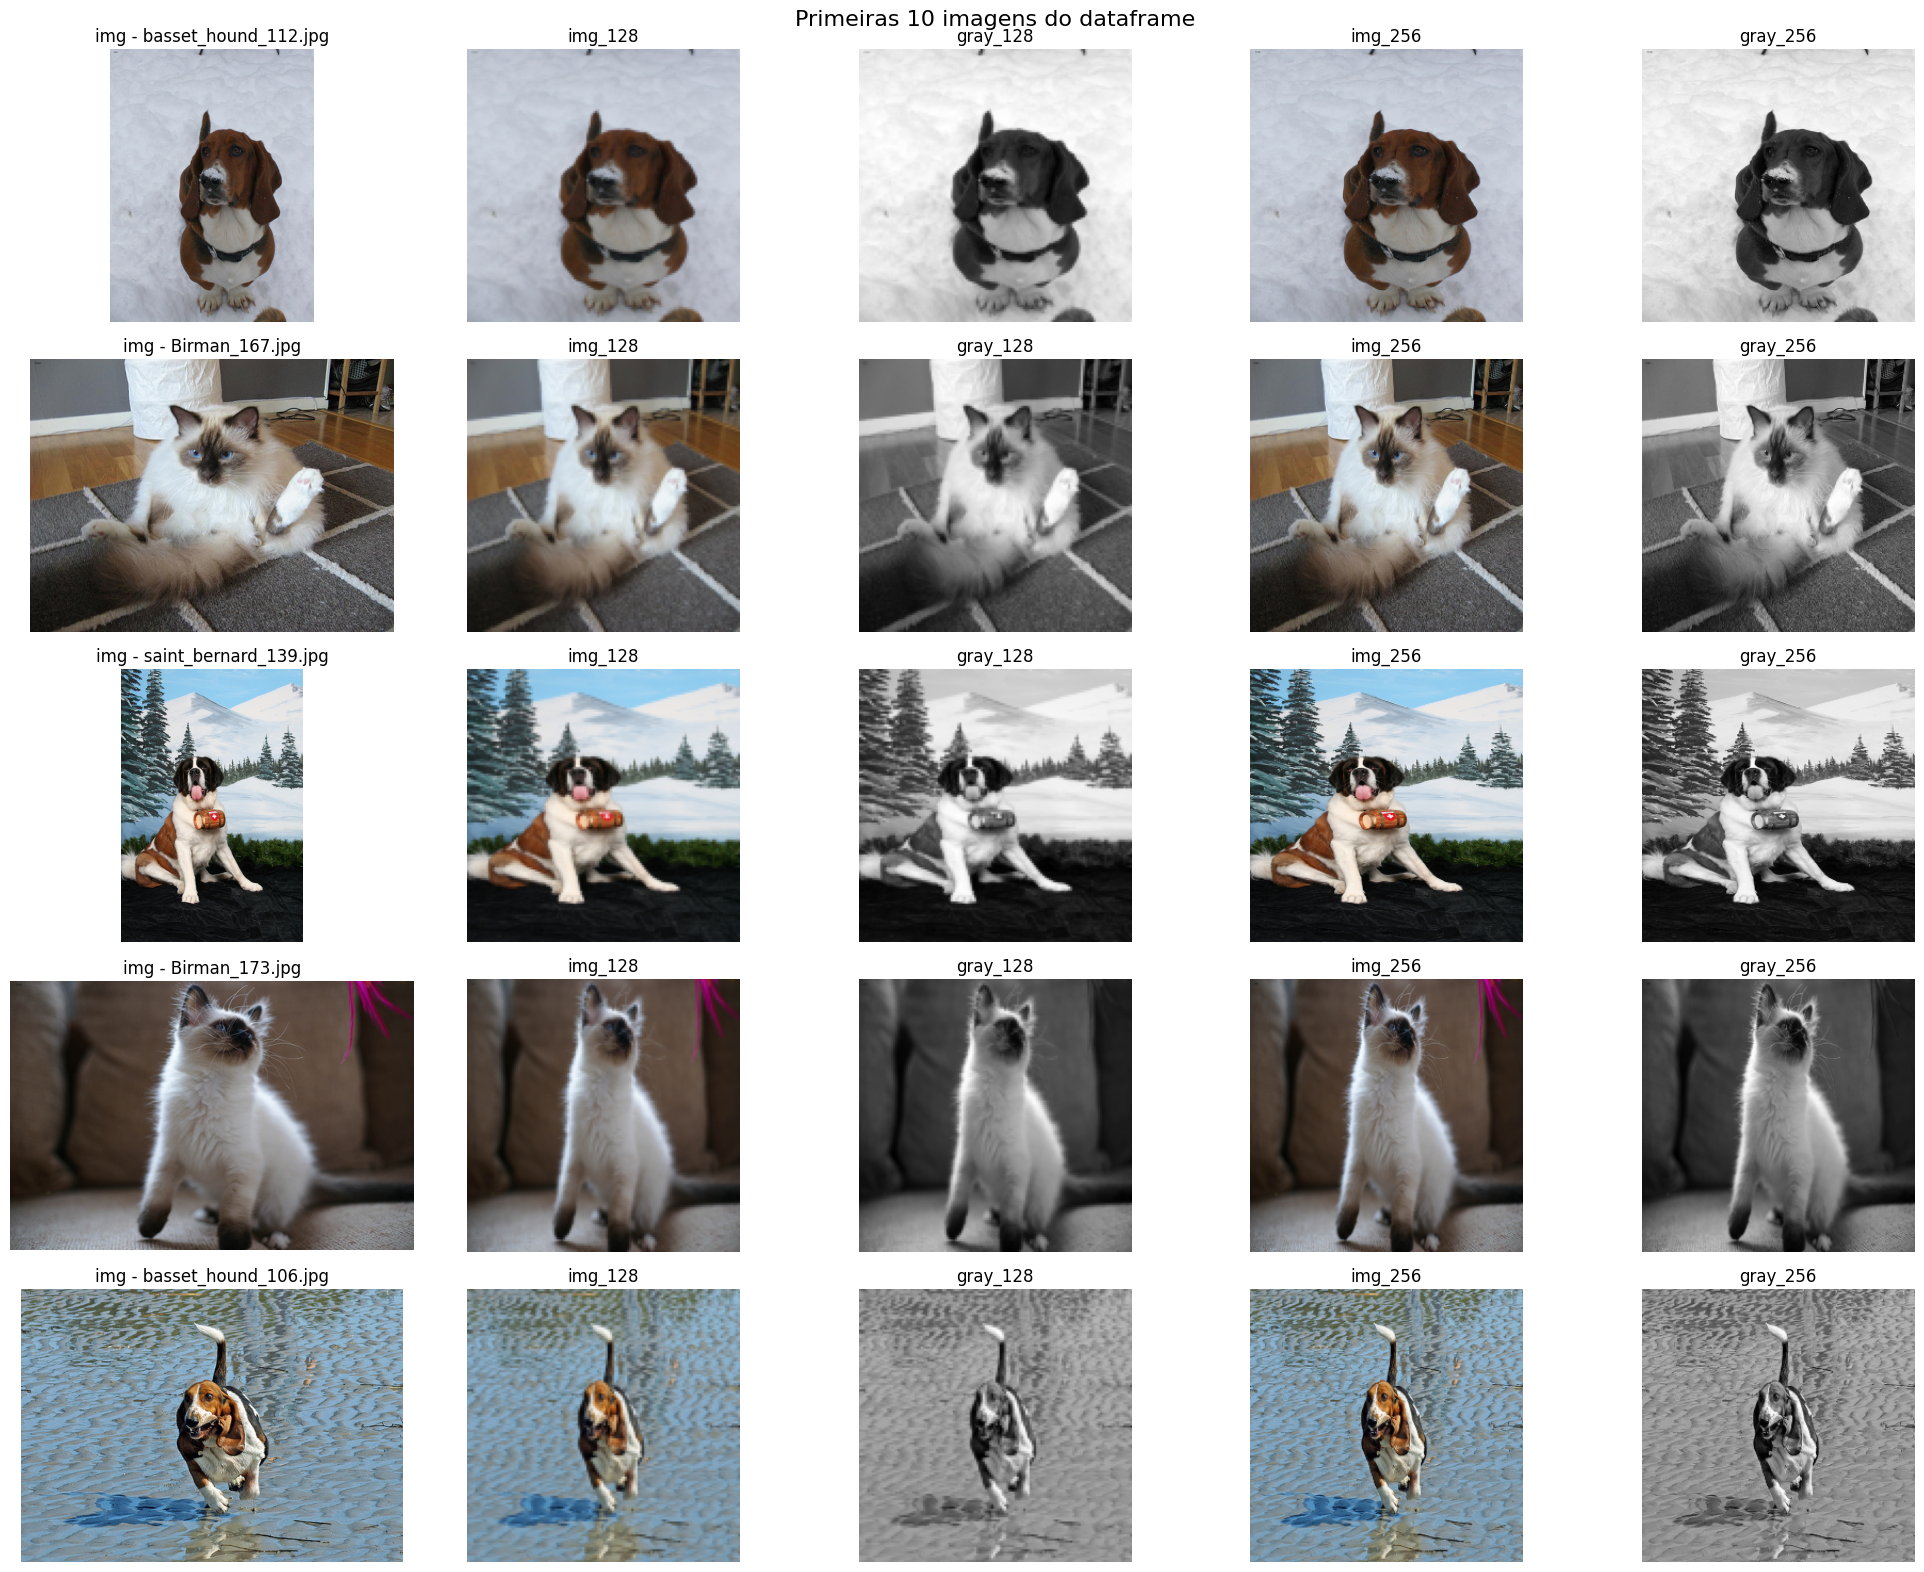

In [4]:

# Exibir as 5 primeiras imagens do dataframe
fig, axes = plt.subplots(5, 5, figsize=(20, 16))
fig.suptitle('Primeiras 10 imagens do dataframe', fontsize=16)

for i in range(5):
    # img
    axes[i, 0].imshow(df_imagens.iloc[i]['img'])
    axes[i, 0].set_title(f'img - {df_imagens.iloc[i]["nome_arquivo"]}')
    axes[i, 0].axis('off')
    
    # img_128
    axes[i, 1].imshow(df_imagens.iloc[i]['img_128'])
    axes[i, 1].set_title('img_128')
    axes[i, 1].axis('off')
    
    # gray_128
    axes[i, 2].imshow(df_imagens.iloc[i]['gray_128'], cmap='gray')
    axes[i, 2].set_title('gray_128')
    axes[i, 2].axis('off')
    
    # img_256
    axes[i, 3].imshow(df_imagens.iloc[i]['img_256'])
    axes[i, 3].set_title('img_256')
    axes[i, 3].axis('off')
    
    # gray_256
    axes[i, 4].imshow(df_imagens.iloc[i]['gray_256'], cmap='gray')
    axes[i, 4].set_title('gray_256')
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

## Adicionar Local Binary Pattern (LBP)

In [5]:
# segundo o artigo referenciado pelo professor, o LBP não varia com a resolução. 
# Logo, vou trabalhar apenas com a resolução 256x256 adicionar mais dois pontos para LBP.
# configurações ( radius, n_points, resolution )
lbp_config = [ 
  (1, 8, 256), 
  (3, 24, 256), 
  (6, 48, 256), 
  (12, 96, 256),
  (24, 192, 256)
] # A ideia é manter uma resolução angular aproximadamente constante (8R).

# Criando colunas LBP com tipo object para armazenar dataframes
for radius, n_points, resolution in lbp_config:
    # df_imagens[f"lbp_{resolution}_{radius}_{n_points}"] = None
    df_imagens[f"lbpfeat_{resolution}_{radius}_{n_points}"] = None

# Processando cada imagem do dataframe com LBP
for idx, row in df_imagens.iterrows():
  print(f"Processando imagem {idx:03d} com LBP: {row['nome_arquivo']}")
  
  for radius, n_points, resolution in lbp_config:
      process_lbp_for_resolution(df_imagens, idx, row[f"gray_{resolution}"], resolution, radius, n_points)


Processando imagem 000 com LBP: basset_hound_112.jpg
	LBP Raio 01 Pontos 008 - 256x256 -	Feature shape: (1, 10)
	LBP Raio 03 Pontos 024 - 256x256 -	Feature shape: (1, 26)
	LBP Raio 06 Pontos 048 - 256x256 -	Feature shape: (1, 50)
	LBP Raio 12 Pontos 096 - 256x256 -	Feature shape: (1, 98)
	LBP Raio 24 Pontos 192 - 256x256 -	Feature shape: (1, 194)
Processando imagem 001 com LBP: Birman_167.jpg
	LBP Raio 01 Pontos 008 - 256x256 -	Feature shape: (1, 10)
	LBP Raio 03 Pontos 024 - 256x256 -	Feature shape: (1, 26)
	LBP Raio 06 Pontos 048 - 256x256 -	Feature shape: (1, 50)
	LBP Raio 12 Pontos 096 - 256x256 -	Feature shape: (1, 98)
	LBP Raio 24 Pontos 192 - 256x256 -	Feature shape: (1, 194)
Processando imagem 002 com LBP: saint_bernard_139.jpg
	LBP Raio 01 Pontos 008 - 256x256 -	Feature shape: (1, 10)
	LBP Raio 03 Pontos 024 - 256x256 -	Feature shape: (1, 26)
	LBP Raio 06 Pontos 048 - 256x256 -	Feature shape: (1, 50)
	LBP Raio 12 Pontos 096 - 256x256 -	Feature shape: (1, 98)
	LBP Raio 24 Ponto

In [6]:
print(f"\nDataFrame de {len(df_imagens)} imagens atualizado com LBP")
print("Novas colunas LBP:\n\t- " + '\n\t- '.join([col for col in df_imagens.columns if 'lbp' in col]))




DataFrame de 800 imagens atualizado com LBP
Novas colunas LBP:
	- lbpfeat_256_1_8
	- lbpfeat_256_3_24
	- lbpfeat_256_6_48
	- lbpfeat_256_12_96
	- lbpfeat_256_24_192


Processando imagem 000 com HOG: basset_hound_112.jpg
	Pixels per cell: 04 - Cells per block: 02 - Orientations: 09 - Resolution: 256 - Shape: (142884,)


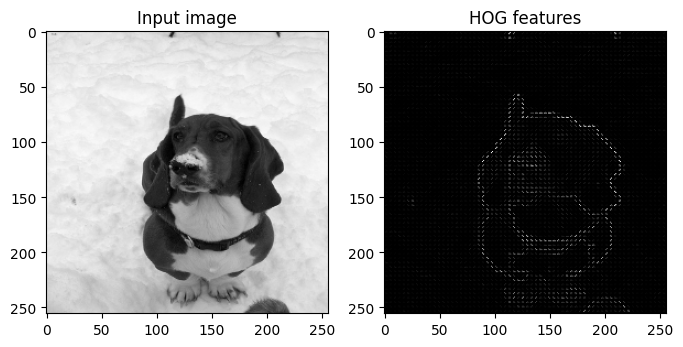

	Pixels per cell: 08 - Cells per block: 02 - Orientations: 09 - Resolution: 128 - Shape: (8100,)


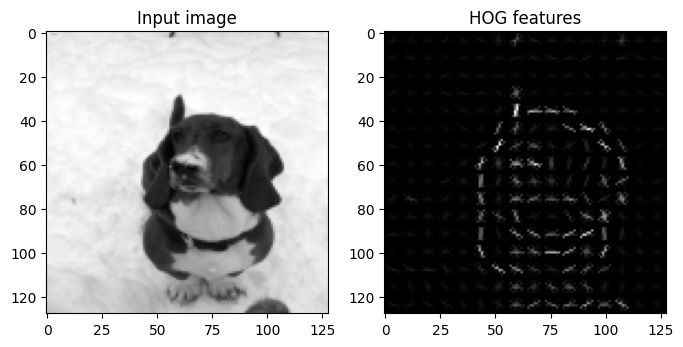

	Pixels per cell: 08 - Cells per block: 02 - Orientations: 09 - Resolution: 256 - Shape: (34596,)


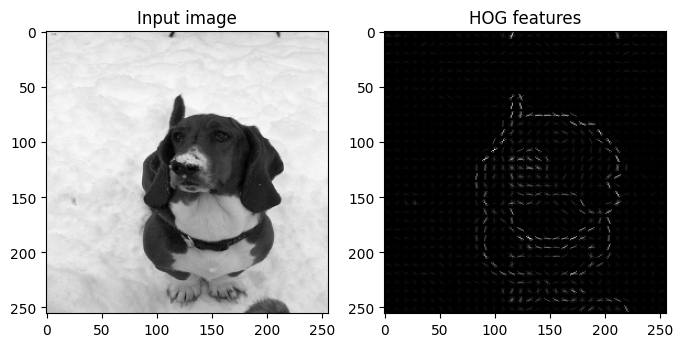

	Pixels per cell: 16 - Cells per block: 02 - Orientations: 09 - Resolution: 128 - Shape: (1764,)


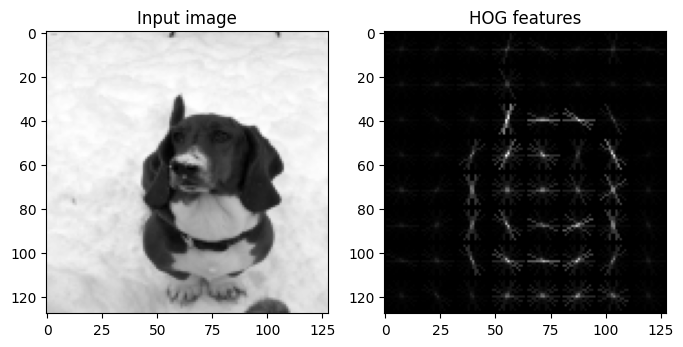

	Pixels per cell: 16 - Cells per block: 04 - Orientations: 09 - Resolution: 128 - Shape: (3600,)


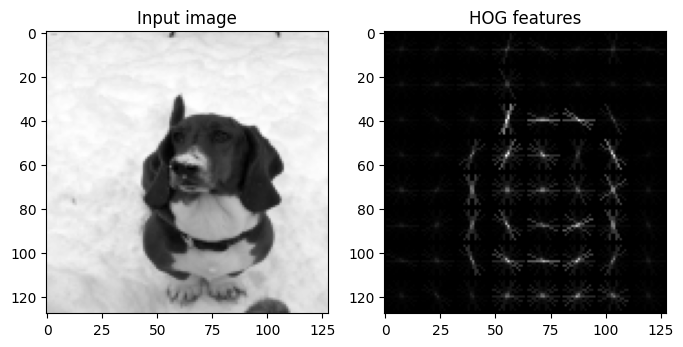

	Pixels per cell: 32 - Cells per block: 02 - Orientations: 09 - Resolution: 256 - Shape: (1764,)


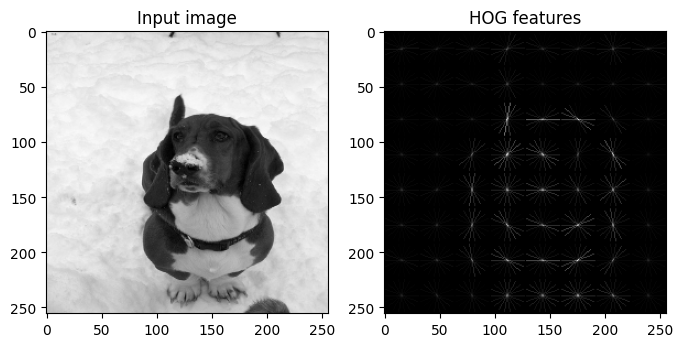

	Pixels per cell: 32 - Cells per block: 02 - Orientations: 09 - Resolution: 128 - Shape: (324,)


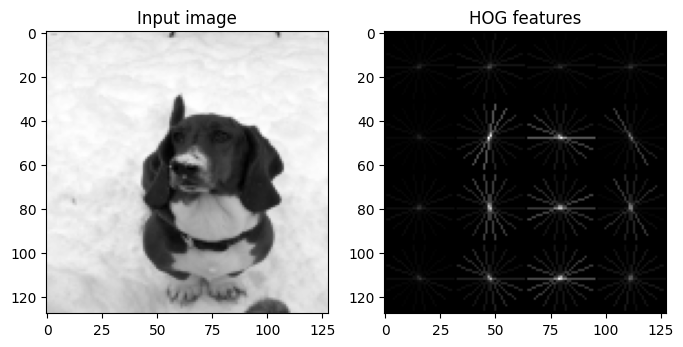

	Pixels per cell: 64 - Cells per block: 02 - Orientations: 09 - Resolution: 256 - Shape: (324,)


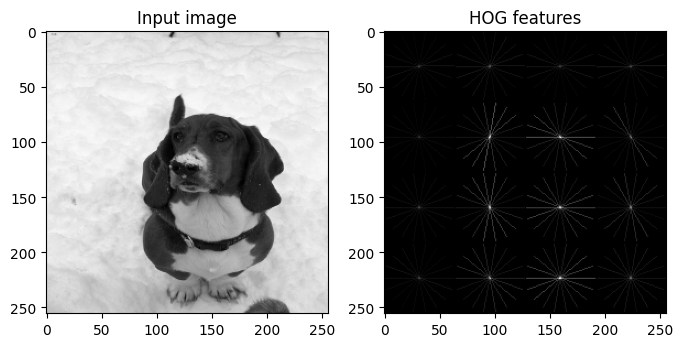

	Pixels per cell: 64 - Cells per block: 02 - Orientations: 18 - Resolution: 256 - Shape: (648,)


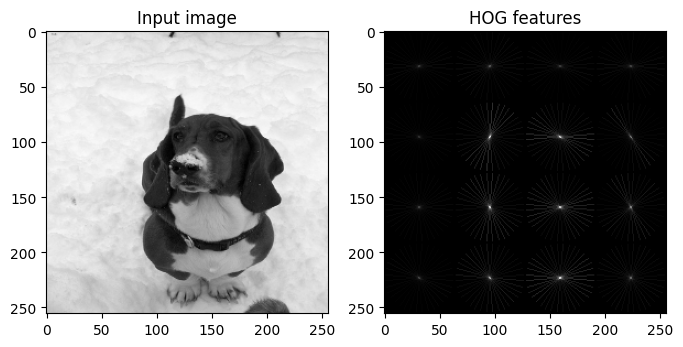

Processando imagem 001 com HOG: Birman_167.jpg
Processando imagem 002 com HOG: saint_bernard_139.jpg
Processando imagem 003 com HOG: Birman_173.jpg
Processando imagem 004 com HOG: basset_hound_106.jpg
Processando imagem 005 com HOG: saint_bernard_111.jpg
Processando imagem 006 com HOG: saint_bernard_105.jpg
Processando imagem 007 com HOG: saint_bernard_2.jpg
Processando imagem 008 com HOG: Birman_2.jpg
Processando imagem 009 com HOG: Birman_198.jpg
Processando imagem 010 com HOG: Persian_221.jpg
Processando imagem 011 com HOG: Persian_143.jpg
Processando imagem 012 com HOG: Birman_49.jpg
Processando imagem 013 com HOG: saint_bernard_41.jpg
Processando imagem 014 com HOG: Persian_75.jpg
Processando imagem 015 com HOG: saint_bernard_55.jpg
Processando imagem 016 com HOG: Persian_61.jpg
Processando imagem 017 com HOG: basset_hound_94.jpg
Processando imagem 018 com HOG: Persian_49.jpg
Processando imagem 019 com HOG: Birman_75.jpg
Processando imagem 020 com HOG: Birman_61.jpg
Processando im

In [7]:
# hog_config (pixels_per_cell, cells_per_block, orientations, resolution, pca_applied)
hog_config = [
  ( 4,  2,  9, 256, True),    # 142.884 atributos → PCA
  ( 8,  2,  9, 128, True),    # 8.100 atributos   → PCA
  ( 8,  2,  9, 256, True),    # 34.596 atributos  → PCA
  (16,  2,  9, 128, True),    # 1.764 atributos   → PCA
  (16,  4,  9, 128, True),    # 3.600 atributos   → PCA
  (32,  2,  9, 256, True),    # 1.764 atributos   → PCA
  (32,  2,  9, 128, False),   # 324 atributos     → sem PCA
  (64,  2,  9, 256, False),   # 324 atributos     → sem PCA
  (64,  2, 18, 256, False),   # 648 atributos     → sem PCA
]

# Criando colunas HOG com tipo object para armazenar dataframes
for ppc, cpb, ori, res, use_pca in hog_config:
    # df_imagens[f"hog_{res}_{ppc}_{cpb}_{ori}"] = None
    df_imagens[f"hogfeat_{res}_{ppc}_{cpb}_{ori}"] = None

detailed_info_until = 1
# Processando cada imagem do dataframe com LBP
for idx, row in df_imagens.iterrows():
  # if idx == detailed_info_until:
  #   break

  print(f"Processando imagem {idx:03d} com HOG: {row['nome_arquivo']}")
  for ppc, cpb, ori, res, use_pca in hog_config:
    #process_hog_for_resolution(df_imagens, idx, row[f"gray_{resolution}"], resolution, orientations, pixels_per_cell, cells_per_block)

    # Extraindo as features do HOG - Imagens em Grayscale
    features_hog, hog_image = hog(
      row[f"gray_{res}"],
      orientations=ori,
      pixels_per_cell=(ppc, ppc),
      cells_per_block=(cpb, cpb),
      visualize=True)

    # df_imagens.at[idx, f"hog_{res}_{ppc}_{cpb}_{ori}"] = features_hog
    df_imagens.at[idx, f"hogfeat_{res}_{ppc}_{cpb}_{ori}"] = convert_from_histogram_to_feature_attributes(features_hog, f"hog_feature")

    if idx < detailed_info_until:
      print(f"\tPixels per cell: {ppc:02d} - Cells per block: {cpb:02d} - Orientations: {ori:02d} - Resolution: {res} - Shape: {features_hog.shape}")
      plt.figure(figsize=(8, 4))
      plt.subplot(1, 2, 1)
      plt.imshow(row[f"gray_{res}"], cmap='gray')
      plt.title('Input image')

      plt.subplot(1, 2, 2)
      plt.imshow(hog_image, cmap='gray')
      plt.title('HOG features')
      plt.show()

In [11]:
print(f"\nDataFrame de {len(df_imagens)} imagens atualizado com HOG")
print("Novas colunas HOG:\n\t- " + '\n\t- '.join([col for col in df_imagens.columns if 'hog' in col]))


DataFrame de 800 imagens atualizado com HOG
Novas colunas HOG:
	- hogfeat_256_4_2_9
	- hogfeat_128_8_2_9
	- hogfeat_256_8_2_9
	- hogfeat_128_16_2_9
	- hogfeat_128_16_4_9
	- hogfeat_256_32_2_9
	- hogfeat_128_32_2_9
	- hogfeat_256_64_2_9
	- hogfeat_256_64_2_18


In [16]:
df_imagens.isna().sum()

nome_arquivo           0
raca                   0
altura                 0
largura                0
img                    0
img_128                0
img_256                0
gray_128               0
gray_256               0
lbpfeat_256_1_8        0
lbpfeat_256_3_24       0
lbpfeat_256_6_48       0
lbpfeat_256_12_96      0
lbpfeat_256_24_192     0
hogfeat_256_4_2_9      0
hogfeat_128_8_2_9      0
hogfeat_256_8_2_9      0
hogfeat_128_16_2_9     0
hogfeat_128_16_4_9     0
hogfeat_256_32_2_9     0
hogfeat_128_32_2_9     0
hogfeat_256_64_2_9     0
hogfeat_256_64_2_18    0
dtype: int64

In [17]:
# Criando dicionário com DataFrames para cada atributo
atributos_dict = {}

# Lista de atributos especificados
atributos = [
    'lbpfeat_256_1_8',
    'lbpfeat_256_3_24', 
    'lbpfeat_256_6_48',
    'lbpfeat_256_12_96',
    'lbpfeat_256_24_192',
    'hogfeat_256_4_2_9',
    'hogfeat_128_8_2_9',
    'hogfeat_256_8_2_9',
    'hogfeat_128_16_2_9',
    'hogfeat_128_16_4_9',
    'hogfeat_256_32_2_9',
    'hogfeat_128_32_2_9',
    'hogfeat_256_64_2_9',
    'hogfeat_256_64_2_18'
]

# Para cada atributo, criar um DataFrame
for atributo in atributos:
    print(f"Processando atributo: {atributo}")
    
    # Lista para armazenar as linhas do DataFrame
    linhas = []
    
    # Iterar sobre cada imagem no DataFrame principal
    for idx, row in df_imagens.iterrows():
        # Verificar se o atributo existe no DataFrame principal
        if atributo in df_imagens.columns:
            # Obter as features do atributo
            features_df = row[atributo]
            linha = {}
            # Se for um DataFrame (features), extrair os valores
            if isinstance(features_df, pd.DataFrame):
                # Converter DataFrame de features para lista de valores
                feature_values = features_df.iloc[0].values.tolist()
                
                # Adicionar cada feature como uma coluna
                for i, valor in enumerate(feature_values):
                    linha[f'feature_{i+1}'] = valor

                # Adicionar nome da imagem e raça
                linha['nome_arquivo'] = row['nome_arquivo']
                linha['raca'] = row['raca']

                linhas.append(linha)
            else:
                print(f"  Aviso: {atributo} não é um DataFrame para imagem {idx}")
        else:
            print(f"  Aviso: {atributo} não encontrado no DataFrame principal")
    
    # Criar DataFrame para este atributo
    if linhas:
        atributos_dict[atributo] = pd.DataFrame(linhas)
        print(f"  DataFrame criado com {len(linhas)} linhas e {len(linhas[0])-2} features")
    else:
        print(f"  Nenhuma linha criada para {atributo}")


Processando atributo: lbpfeat_256_1_8
  DataFrame criado com 800 linhas e 10 features
Processando atributo: lbpfeat_256_3_24
  DataFrame criado com 800 linhas e 26 features
Processando atributo: lbpfeat_256_6_48
  DataFrame criado com 800 linhas e 50 features
Processando atributo: lbpfeat_256_12_96
  DataFrame criado com 800 linhas e 98 features
Processando atributo: lbpfeat_256_24_192
  DataFrame criado com 800 linhas e 194 features
Processando atributo: hogfeat_256_4_2_9
  DataFrame criado com 800 linhas e 142884 features
Processando atributo: hogfeat_128_8_2_9
  DataFrame criado com 800 linhas e 8100 features
Processando atributo: hogfeat_256_8_2_9
  DataFrame criado com 800 linhas e 34596 features
Processando atributo: hogfeat_128_16_2_9
  DataFrame criado com 800 linhas e 1764 features
Processando atributo: hogfeat_128_16_4_9
  DataFrame criado com 800 linhas e 3600 features
Processando atributo: hogfeat_256_32_2_9
  DataFrame criado com 800 linhas e 1764 features
Processando atri

In [21]:

print(f"\nDicionário criado com {len(atributos_dict)} atributos")
# Mostrar atributos em formato vertical
print("Atributos disponíveis no atributos_dict:")
for i, atributo in enumerate(atributos_dict.keys(), 1):
    print(f"  {i:2d}. {atributo}")


Dicionário criado com 14 atributos
Atributos disponíveis no atributos_dict:
   1. lbpfeat_256_1_8
   2. lbpfeat_256_3_24
   3. lbpfeat_256_6_48
   4. lbpfeat_256_12_96
   5. lbpfeat_256_24_192
   6. hogfeat_256_4_2_9
   7. hogfeat_128_8_2_9
   8. hogfeat_256_8_2_9
   9. hogfeat_128_16_2_9
  10. hogfeat_128_16_4_9
  11. hogfeat_256_32_2_9
  12. hogfeat_128_32_2_9
  13. hogfeat_256_64_2_9
  14. hogfeat_256_64_2_18


In [23]:
# utilizando hog_config como parametro para identificar quais atributos de atributos_dict processar,
# simplifique as features HOG aplicando PCA a 75% de variancia, e adicionando o resultado de volta 
# em atributos_dict, sufixando o nome do atributo com _pca.
# Para tanto, os atributos nome_arquivo e raca devem ser preservados no resultado com PCA.

# Identificar quais atributos HOG devem ter PCA aplicado
atributos_hog_pca = []
for ppc, cpb, ori, res, use_pca in hog_config:
    if use_pca:
        atributo = f"hogfeat_{res}_{ppc}_{cpb}_{ori}"
        atributos_hog_pca.append(atributo)

print(f"Atributos HOG que terão PCA aplicado: {atributos_hog_pca}")

# Aplicar PCA para cada atributo HOG especificado usando dados já processados em atributos_dict
for atributo in atributos_hog_pca:
    if atributo in atributos_dict:
        print(f"\nProcessando PCA para {atributo}...")
        
        # Usar DataFrame já processado do atributos_dict
        df_atributo = atributos_dict[atributo]
        print(f"  Shape original: {df_atributo.shape}")
        
        # Separar features dos metadados
        feature_cols = [col for col in df_atributo.columns if col.startswith('feature_')]
        features_matrix = df_atributo[feature_cols].values
        metadados = df_atributo[['nome_arquivo', 'raca']].values
        
        # Aplicar PCA com 75% de variância
        features_pca = apply_pca(features_matrix, 0.75)
        print(f"  Shape após PCA: {features_pca.shape}")
        
        # Criar novo DataFrame com features PCA + metadados
        linhas_pca = []
        for i, (nome_arquivo, raca) in enumerate(metadados):
            linha = {}
            
            # Adicionar features PCA primeiro
            for j, valor in enumerate(features_pca[i]):
                linha[f'feature_{j+1}'] = valor
            
            # Adicionar metadados por último
            linha['nome_arquivo'] = nome_arquivo
            linha['raca'] = raca
            
            linhas_pca.append(linha)
        
        # Criar DataFrame e adicionar ao atributos_dict com sufixo _pca
        atributo_pca = f"{atributo}_pca"
        atributos_dict[atributo_pca] = pd.DataFrame(linhas_pca)
        print(f"  DataFrame {atributo_pca} criado com shape: {atributos_dict[atributo_pca].shape}")
    else:
        print(f"  Aviso: {atributo} não encontrado em atributos_dict")

print(f"\nProcessamento PCA concluído!")

Atributos HOG que terão PCA aplicado: ['hogfeat_256_4_2_9', 'hogfeat_128_8_2_9', 'hogfeat_256_8_2_9', 'hogfeat_128_16_2_9', 'hogfeat_128_16_4_9', 'hogfeat_256_32_2_9']

Processando PCA para hogfeat_256_4_2_9...
  Shape original: (800, 142886)
  Shape após PCA: (800, 507)
  DataFrame hogfeat_256_4_2_9_pca criado com shape: (800, 509)

Processando PCA para hogfeat_128_8_2_9...
  Shape original: (800, 8102)
  Shape após PCA: (800, 287)
  DataFrame hogfeat_128_8_2_9_pca criado com shape: (800, 289)

Processando PCA para hogfeat_256_8_2_9...
  Shape original: (800, 34598)
  Shape após PCA: (800, 394)
  DataFrame hogfeat_256_8_2_9_pca criado com shape: (800, 396)

Processando PCA para hogfeat_128_16_2_9...
  Shape original: (800, 1766)
  Shape após PCA: (800, 117)
  DataFrame hogfeat_128_16_2_9_pca criado com shape: (800, 119)

Processando PCA para hogfeat_128_16_4_9...
  Shape original: (800, 3602)
  Shape após PCA: (800, 103)
  DataFrame hogfeat_128_16_4_9_pca criado com shape: (800, 105)


In [24]:
# Mostrar atributos em formato vertical (após aplicação do PCA)
print(f"\nDicionário atualizado com {len(atributos_dict)} atributos após aplicação do PCA")
print("Atributos disponíveis no atributos_dict:")
for i, atributo in enumerate(atributos_dict.keys(), 1):
    print(f"  {i:2d}. {atributo}")



Dicionário atualizado com 20 atributos após aplicação do PCA
Atributos disponíveis no atributos_dict:
   1. lbpfeat_256_1_8
   2. lbpfeat_256_3_24
   3. lbpfeat_256_6_48
   4. lbpfeat_256_12_96
   5. lbpfeat_256_24_192
   6. hogfeat_256_4_2_9
   7. hogfeat_128_8_2_9
   8. hogfeat_256_8_2_9
   9. hogfeat_128_16_2_9
  10. hogfeat_128_16_4_9
  11. hogfeat_256_32_2_9
  12. hogfeat_128_32_2_9
  13. hogfeat_256_64_2_9
  14. hogfeat_256_64_2_18
  15. hogfeat_256_4_2_9_pca
  16. hogfeat_128_8_2_9_pca
  17. hogfeat_256_8_2_9_pca
  18. hogfeat_128_16_2_9_pca
  19. hogfeat_128_16_4_9_pca
  20. hogfeat_256_32_2_9_pca


In [26]:
# Para cada atributo, exibe as duas primeiras colunas e as duas últimas das duas primeiras linhas do DataFrame correspondente
for atributo, df in atributos_dict.items():
    print(f"\nAtributo: {atributo}")
    # Seleciona as duas primeiras linhas
    primeiras_linhas = df.iloc[:2]
    # Seleciona as duas primeiras e duas últimas colunas
    colunas_desejadas = list(primeiras_linhas.columns[:2]) + list(primeiras_linhas.columns[-2:])
    print(primeiras_linhas[colunas_desejadas])



Atributo: lbpfeat_256_1_8
   feature_1  feature_2          nome_arquivo          raca
0   0.078171   0.079361  basset_hound_112.jpg  basset_hound
1   0.098129   0.095795        Birman_167.jpg        Birman

Atributo: lbpfeat_256_3_24
   feature_1  feature_2          nome_arquivo          raca
0   0.049606   0.024933  basset_hound_112.jpg  basset_hound
1   0.054031   0.033646        Birman_167.jpg        Birman

Atributo: lbpfeat_256_6_48
   feature_1  feature_2          nome_arquivo          raca
0   0.040878   0.014969  basset_hound_112.jpg  basset_hound
1   0.033020   0.017792        Birman_167.jpg        Birman

Atributo: lbpfeat_256_12_96
   feature_1  feature_2          nome_arquivo          raca
0   0.028595   0.008392  basset_hound_112.jpg  basset_hound
1   0.019699   0.009903        Birman_167.jpg        Birman

Atributo: lbpfeat_256_24_192
   feature_1  feature_2          nome_arquivo          raca
0   0.022141   0.004883  basset_hound_112.jpg  basset_hound
1   0.016876   0.0

In [37]:
# Salva cada DataFrame do dicionário atributos_dict em um arquivo CSV com o nome do atributo
for atributo, df in atributos_dict.items():
    print(f"Salvando DataFrame: {atributo}")
    df.to_csv(f"{atributo}.csv", index=False)


Salvando DataFrame: lbpfeat_256_1_8
Salvando DataFrame: lbpfeat_256_3_24
Salvando DataFrame: lbpfeat_256_6_48
Salvando DataFrame: lbpfeat_256_12_96
Salvando DataFrame: lbpfeat_256_24_192
Salvando DataFrame: hogfeat_256_4_2_9
Salvando DataFrame: hogfeat_128_8_2_9
Salvando DataFrame: hogfeat_256_8_2_9
Salvando DataFrame: hogfeat_128_16_2_9
Salvando DataFrame: hogfeat_128_16_4_9
Salvando DataFrame: hogfeat_256_32_2_9
Salvando DataFrame: hogfeat_128_32_2_9
Salvando DataFrame: hogfeat_256_64_2_9
Salvando DataFrame: hogfeat_256_64_2_18
Salvando DataFrame: hogfeat_256_4_2_9_pca
Salvando DataFrame: hogfeat_128_8_2_9_pca
Salvando DataFrame: hogfeat_256_8_2_9_pca
Salvando DataFrame: hogfeat_128_16_2_9_pca
Salvando DataFrame: hogfeat_128_16_4_9_pca
Salvando DataFrame: hogfeat_256_32_2_9_pca
